# DSML - Airbnb - Seoul


** This is an exercise to study the data for Airbnb Seoul. **


Source of data:
1. http://tomslee.net/airbnb-data-collection-get-the-data
2. https://s3.amazonaws.com/tomslee-airbnb-data-2/seoul.zip


Discovery:
1. Reviews vs satisfaction : 
   - Intuitively, room with high satisfaction attracts more customers, and hence higher no. of review 
   - does it affect on the data?
2. neighbourhood vs price : 
   - Which location in Seoul are the most expensive/cheapest?
3. accommodates vs bedroom:  
   - Will a crowded bedroom lead to worse satisfaction? and could this be compensate by having a lower price? 
4. more advanced: 
   - visualize the overall distributions of houses on a map, using the lat/long


In [1]:
#load packages
import glob
import os
import sys
import pandas as pd
import numpy as np
#Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns

from scipy import stats
from scipy.stats import norm, skew #for some statistics
import sklearn

from sklearn.metrics import make_scorer, mean_squared_error

print("Python version: {}". format(sys.version))
print("pandas version: {}". format(pd.__version__))
print("NumPy version: {}". format(np.__version__))
print("scikit-learn version: {}". format(sklearn.__version__))
print('-'*25)

#Configure Visualization Defaults
#%matplotlib inline = show plots in Jupyter Notebook browser
mpl.style.use('ggplot')
sns.set_style('white')
pylab.rcParams['figure.figsize'] = 12,8
%matplotlib inline

for i in os.listdir("./seoul"):
    print(i)


Python version: 3.6.4 |Anaconda, Inc.| (default, Jan 16 2018, 10:22:32) [MSC v.1900 64 bit (AMD64)]
pandas version: 0.22.0
NumPy version: 1.14.0
scikit-learn version: 0.19.1
-------------------------
tomslee_airbnb_seoul_0438_2016-05-29.csv
tomslee_airbnb_seoul_0593_2016-10-02.csv
tomslee_airbnb_seoul_0759_2016-12-28.csv
tomslee_airbnb_seoul_0793_2017-01-15.csv
tomslee_airbnb_seoul_0794_2017-01-15.csv
tomslee_airbnb_seoul_0877_2017-02-11.csv
tomslee_airbnb_seoul_0985_2017-03-24.csv
tomslee_airbnb_seoul_1062_2017-04-12.csv
tomslee_airbnb_seoul_1131_2017-04-21.csv
tomslee_airbnb_seoul_1210_2017-05-10.csv
tomslee_airbnb_seoul_1334_2017-06-14.csv
tomslee_airbnb_seoul_1462_2017-07-17.csv


### Prepare data sets

In [2]:
seoul_airbnb = pd.read_csv('./seoul/tomslee_airbnb_seoul_1462_2017-07-17.csv')
print(seoul_airbnb.shape)
print()
print(seoul_airbnb.info())

(12406, 19)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12406 entries, 0 to 12405
Data columns (total 19 columns):
room_id                 12406 non-null int64
survey_id               12406 non-null int64
host_id                 12406 non-null int64
room_type               12406 non-null object
country                 0 non-null float64
city                    12406 non-null object
borough                 0 non-null float64
neighborhood            12406 non-null object
reviews                 12406 non-null int64
overall_satisfaction    12406 non-null float64
accommodates            12406 non-null int64
bedrooms                12406 non-null float64
bathrooms               0 non-null float64
price                   12406 non-null float64
minstay                 0 non-null float64
last_modified           12406 non-null object
latitude                12406 non-null float64
longitude               12406 non-null float64
location                12406 non-null object
dtypes: float64(

## Select the useful columns
- room_id: 
  - A unique number identifying an Airbnb listing. The listing has a URL on the Airbnb web site of http://airbnb.com/rooms/room_id
- host_id: 
  - A unique number identifying an Airbnb host. The host’s page has a URL on the Airbnb web site of http://airbnb.com/users/show/host_id
- room_type: 
  - One of “Entire home/apt”, “Private room”, or “Shared room”
- borough: 
  - A subregion of the city or search area for which the survey is carried out. The borough is taken from a shapefile of the city that is obtained independently of the Airbnb web site. For some cities, there is no borough information; for others the borough may be a number. If you have better shapefiles for a city of interest, please send them to me.
- neighborhood: 
  - As with borough: a subregion of the city or search area for which the survey is carried out. For cities that have both, a neighbourhood is smaller than a borough. For some cities there is no neighbourhood information.
- reviews: 
  - The number of reviews that a listing has received. Airbnb has said that 70% of visits end up with a review, so the number of reviews can be used to estimate the number of visits. Note that such an estimate will not be reliable for an individual listing (especially as reviews occasionally vanish from the site), but over a city as a whole it should be a useful metric of traffic.
- overall_satisfaction: 
  - The average rating (out of five) that the listing has received from those visitors who left a review.
- accommodates: 
  - The number of guests a listing can accommodate.
- bedrooms: 
  - The number of bedrooms a listing offers.
- price: 
  - The price (in $US) for a night stay. In early surveys, there may be some values that were recorded by month.
- minstay: 
  - The minimum stay for a visit, as posted by the host.
- latitude and longitude: 
  - The latitude and longitude of the listing as posted on the Airbnb site: this may be off by a few hundred metres. I do not have a way to track individual listing locations with
- last_modified: 
  - the date and time that the values were read from the Airbnb web site.


In [3]:
#print(np.argwhere(np.isnan(seoul_airbnb['log_price'])))
print(pd.isnull(seoul_airbnb).sum().sort_index())
seoul_airbnb.describe()

accommodates                0
bathrooms               12406
bedrooms                    0
borough                 12406
city                        0
country                 12406
host_id                     0
last_modified               0
latitude                    0
location                    0
longitude                   0
minstay                 12406
neighborhood                0
overall_satisfaction        0
price                       0
reviews                     0
room_id                     0
room_type                   0
survey_id                   0
dtype: int64


,room_id,survey_id,host_id,country,borough,reviews,overall_satisfaction,accommodates,bedrooms,bathrooms,price,minstay,latitude,longitude
count,1.240600e+04,12406.0,1.240600e+04,0.0,0.0,12406.000000,12406.000000,12406.000000,12406.000000,0.0,12406.000000,0.0,12406.000000,12406.000000
mean,1.287025e+07,1462.0,4.953678e+07,NaN,NaN,13.241335,2.639368,3.593342,1.237546,NaN,62.562873,NaN,37.546716,126.976406
std,5.455167e+06,0.0,3.781907e+07,NaN,NaN,21.172342,2.358713,2.732305,1.004181,NaN,115.536090,NaN,0.030531,0.055188
min,3.510800e+04,1462.0,4.983200e+04,NaN,NaN,0.000000,0.000000,1.000000,0.000000,NaN,0.000000,NaN,37.445828,126.801683
25%,8.732277e+06,1462.0,1.798644e+07,NaN,NaN,0.000000,0.000000,2.000000,1.000000,NaN,32.000000,NaN,37.529392,126.927422
50%,1.440717e+07,1462.0,3.998685e+07,NaN,NaN,4.000000,4.500000,3.000000,1.000000,NaN,46.000000,NaN,37.555250,126.975958
75%,1.743638e+07,1462.0,7.518510e+07,NaN,NaN,17.000000,5.000000,4.000000,1.000000,NaN,68.000000,NaN,37.562569,127.017311
max,1.990404e+07,1462.0,1.409437e+08,NaN,NaN,210.000000,5.000000,16.000000,46.000000,NaN,10376.000000,NaN,37.686420,127.179640



```
accommodates                 0
bathrooms                12406 --> ignore
bedrooms                     0
borough                  12406 --> ignore
city                         0 --> ignore (all data from same city: seoul)
country                  12406 --> ignore
host_id                      0
last_modified                0
latitude                     0
location                     0 --> ignore
longitude                    0
minstay                  12406 --> ignore
neighborhood                 0
overall_satisfaction         0
price                        0
reviews                      0
room_id                      0
room_type                    0
survey_id                    0 --> ignore
```


In [4]:
seoul_airbnb['city'].value_counts()

Seoul    12406
Name: city, dtype: int64

In [5]:
columns_useful = ['latitude', 'longitude', 'room_type', 'accommodates', 'bedrooms', 'neighborhood', 'price', 'reviews', 'overall_satisfaction']
seoul_airbnb[columns_useful].sample(10)

,latitude,longitude,room_type,accommodates,bedrooms,neighborhood,price,reviews,overall_satisfaction
6628,37.541466,126.949937,Entire home/apt,3,1.0,Dohwa-dong,34.0,59,5.0
2940,37.565569,127.008640,Entire home/apt,2,0.0,Euljiro 7(chil)-ga,88.0,0,0.0
9084,37.557205,126.983435,Private room,3,1.0,Hoehyeon-dong 2(i)-ga,55.0,42,4.5
3051,37.533667,126.992457,Entire home/apt,6,2.0,Itaewon-dong,82.0,36,4.5
3106,37.557066,126.923634,Entire home/apt,2,1.0,Donggyo-dong,65.0,4,5.0
9920,37.548512,126.967007,Private room,2,1.0,Cheongpa-dong 1(il)-ga,23.0,18,5.0
9458,37.559471,126.985461,Private room,2,1.0,Namsan-dong 2(i)-ga,42.0,39,4.5
7232,37.545037,127.023076,Private room,2,1.0,Geumho-dong 4(sa)-ga,191.0,0,0.0
5143,37.585314,126.995708,Entire home/apt,16,10.0,Myeongnyun 3(sam)-ga,57.0,1,0.0
6878,37.562805,127.035332,Entire home/apt,2,1.0,Doseon-dong,37.0,12,5.0


In [6]:
corr_mx = seoul_airbnb[columns_useful].corr()

corr_mx #["overall_satisfaction"].sort_values(ascending=False)

,latitude,longitude,accommodates,bedrooms,price,reviews,overall_satisfaction
latitude,1.000000,-0.203042,0.065341,0.018036,0.000049,0.026502,0.003655
longitude,-0.203042,1.000000,-0.071038,-0.022461,0.036695,-0.037872,-0.030568
accommodates,0.065341,-0.071038,1.000000,0.544730,0.251157,0.094230,0.096222
bedrooms,0.018036,-0.022461,0.544730,1.000000,0.214689,-0.010447,-0.006270
price,0.000049,0.036695,0.251157,0.214689,1.000000,-0.031425,-0.062221
reviews,0.026502,-0.037872,0.094230,-0.010447,-0.031425,1.000000,0.541234
overall_satisfaction,0.003655,-0.030568,0.096222,-0.006270,-0.062221,0.541234,1.000000


#### correlation 
1. Accomodates and Bedrooms : 0.544730
2. Reviews and overall_satisfaction : 0.541234
3. Price and Accomodates, Bedrooms : 0.251157 , 0.214689

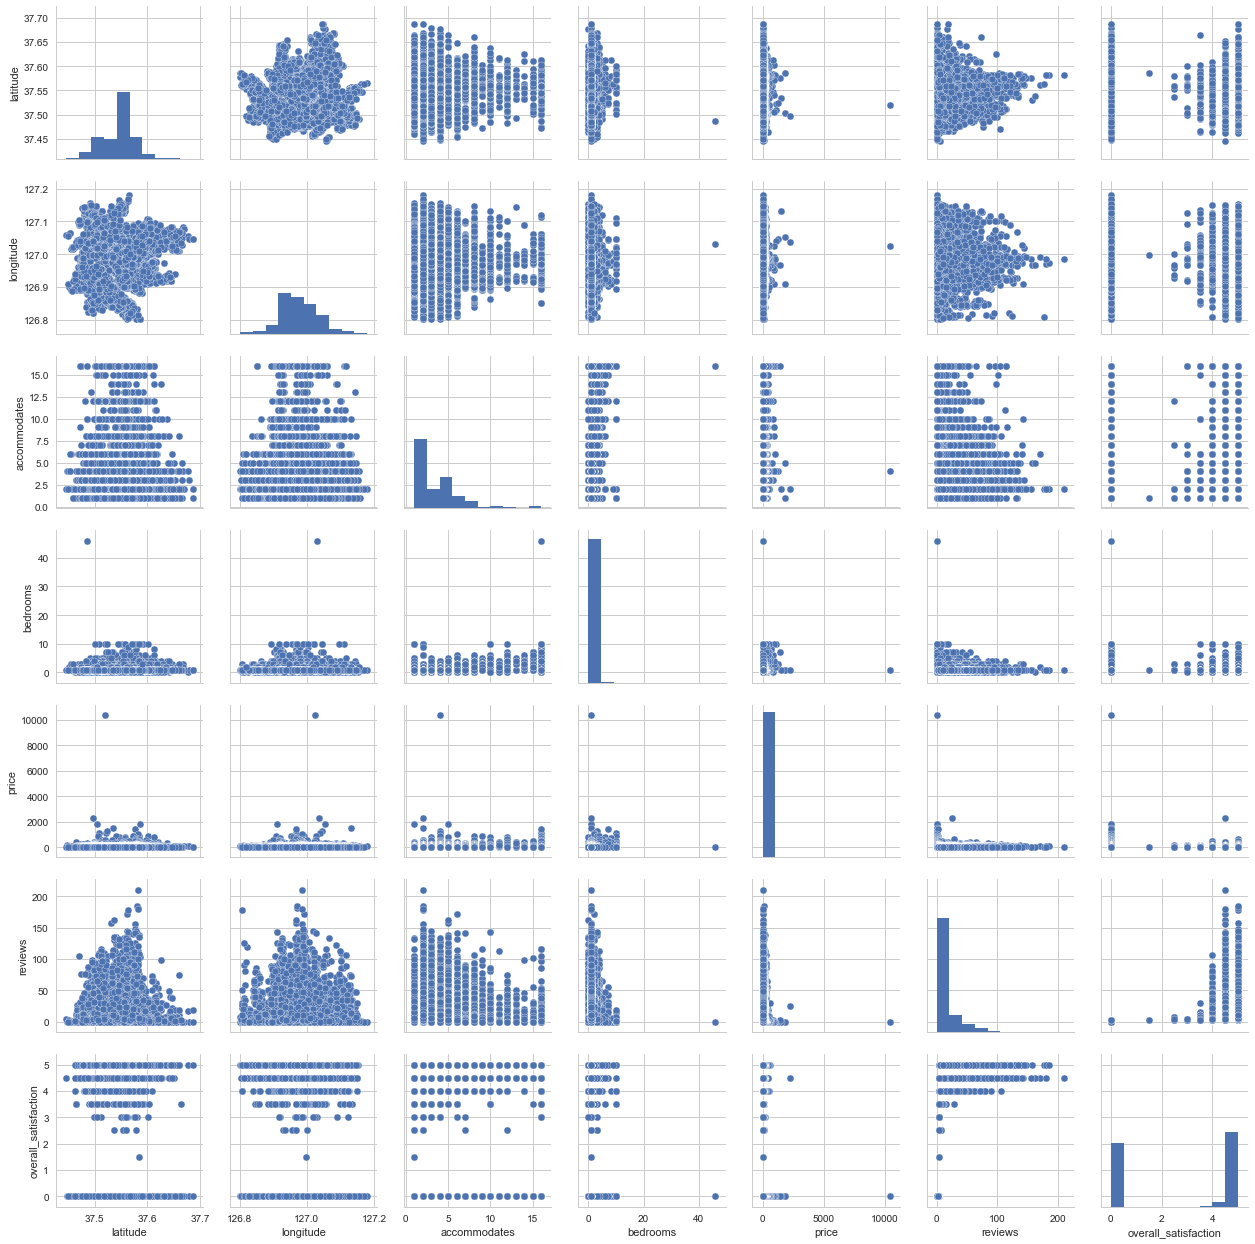

In [7]:
sns.set(style = 'whitegrid', context='notebook')
sns.pairplot(seoul_airbnb[columns_useful], size=2.5)
plt.show()

##  Review VS Satisfaction

** Room type ** is categorical value, Convert the column to a number
- Entire home/apt    1
- Private room       2
- Shared room        3

In [8]:
review_satisfy = seoul_airbnb[['room_type', 'reviews','overall_satisfaction']].copy()
review_satisfy["room_type"] = review_satisfy["room_type"].astype('category')
#review_satisfy["room_type_num"] = review_satisfy["room_type"].cat.codes
#review_satisfy['score'] = review_satisfy['reviews'] * review_satisfy['overall_satisfaction']

review_satisfy.sample(10)

,room_type,reviews,overall_satisfaction
7931,Private room,1,0.0
11833,Private room,90,4.5
8004,Private room,35,5.0
12292,Private room,0,0.0
12084,Private room,82,5.0
2204,Entire home/apt,1,0.0
5865,Entire home/apt,2,0.0
10738,Private room,0,0.0
4824,Entire home/apt,4,5.0
1639,Entire home/apt,0,0.0


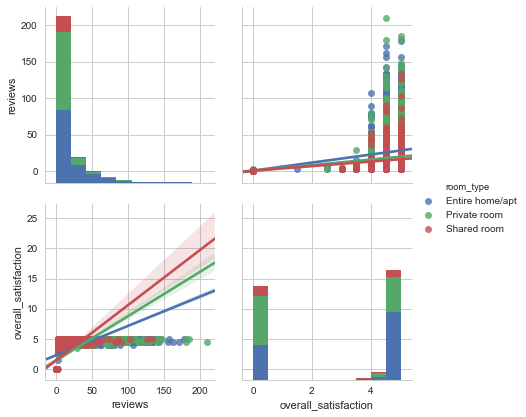

In [9]:
#fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4), sharey=True)

sns.set(style = 'whitegrid', context='notebook')
sns.pairplot(review_satisfy, hue="room_type", kind='reg', size=3)
plt.show()

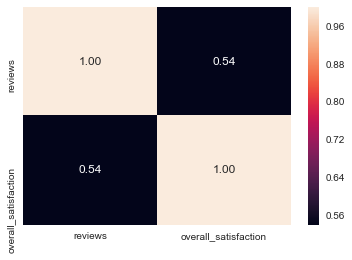

In [10]:
sns.heatmap(review_satisfy.corr(), annot=True, fmt=".2f")

In [11]:
#room_review = seoul_airbnb[['room_type','reviews']].copy()
#review_satisfy.groupby(['room_type','overall_satisfaction'])['reviews'].sum(skipna=False)
review_satisfy.groupby(['room_type','overall_satisfaction'])['reviews'].sum().unstack().fillna(0)

overall_satisfaction,0.0,1.5,2.5,3.0,3.5,4.0,4.5,5.0
room_type,,,,,,,,
Entire home/apt,1076.0,3.0,24.0,16.0,146.0,3315.0,44362.0,64177.0
Private room,1372.0,0.0,7.0,28.0,262.0,2418.0,15435.0,23983.0
Shared room,311.0,0.0,0.0,9.0,58.0,544.0,3256.0,3470.0


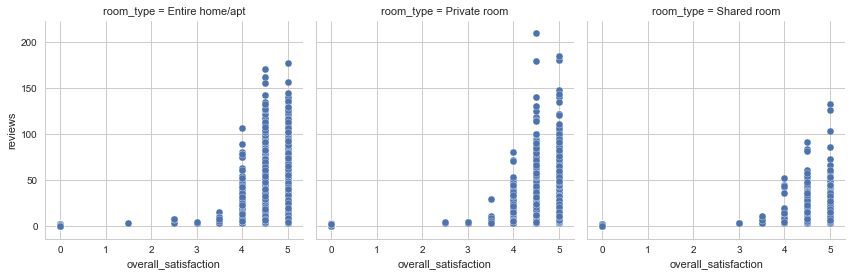

In [12]:
g = sns.FacetGrid(review_satisfy, col="room_type", size=4, aspect=1)
#g = g.map(plt.hist, "overall_satisfaction")
g = g.map(plt.scatter, "overall_satisfaction", "reviews", edgecolor="w")

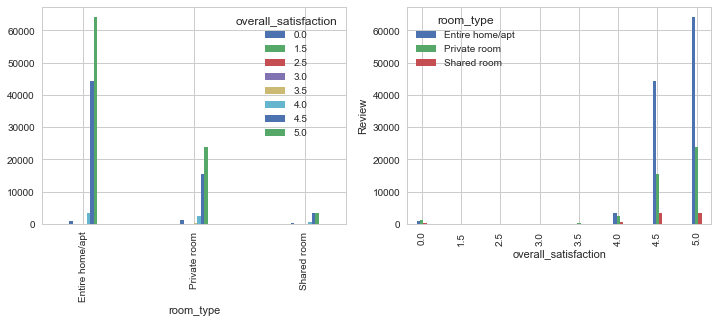

In [13]:
rstab1 = pd.crosstab(index=review_satisfy['room_type'], columns=review_satisfy['overall_satisfaction'], values=review_satisfy['reviews'], aggfunc='sum')
rstab1.fillna(0)

rstab2 = pd.crosstab(index=review_satisfy['overall_satisfaction'], columns=review_satisfy['room_type'], values=review_satisfy['reviews'], aggfunc='sum')
rstab2.fillna(0)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4), sharey=False)

rstab1.plot.bar(width=0.25, align='center', stacked=False, ax=ax1)
rstab2.plot.bar(width=0.25, align='center', stacked=False, ax=ax2)
plt.ylabel('Review')
plt.show()

## Room Type VS Satisfaction  

In [14]:
room_satisfy = seoul_airbnb[['room_type','overall_satisfaction','price']].copy()
room_satisfy["overall_satisfaction"].value_counts().sort_index()

0.0    5470
1.5       1
2.5       6
3.0      16
3.5      85
4.0     430
4.5    2656
5.0    3742
Name: overall_satisfaction, dtype: int64

In [15]:
rstab1 = room_satisfy.groupby(['room_type'])["overall_satisfaction"].value_counts().unstack().fillna(0)
rstab1

overall_satisfaction,0.0,1.5,2.5,3.0,3.5,4.0,4.5,5.0
room_type,,,,,,,,
Entire home/apt,2003.0,1.0,4.0,5.0,28.0,188.0,1599.0,2344.0
Private room,2895.0,0.0,2.0,8.0,47.0,197.0,841.0,1186.0
Shared room,572.0,0.0,0.0,3.0,10.0,45.0,216.0,212.0


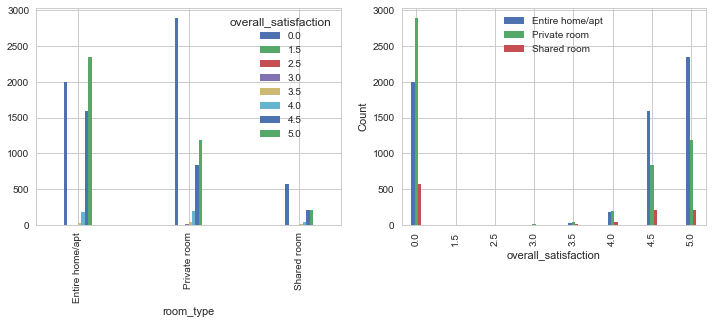

In [16]:

rstab2 = room_satisfy.groupby(['overall_satisfaction'])["room_type"].value_counts().unstack().fillna(0)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4), sharey=False)

rstab1.plot.bar(width=0.25, align='center', stacked=False, ax=ax1)
rstab2.plot.bar(width=0.25, align='center', stacked=False, ax=ax2)
ax2.legend(loc='upper center')
          
plt.ylabel('Count')
plt.show()

## Room Type VS Price

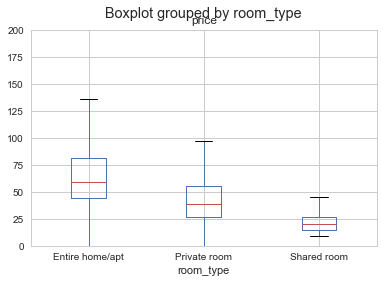

In [39]:
room_satisfy.boxplot(column="price",         # Column to plot
            by= "room_type",         # Column to split upon
            figsize= (6,4))        # Figure size
plt.ylim(0,200)
plt.show()

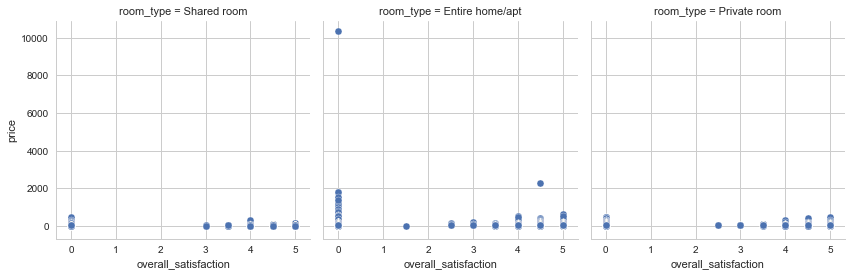

In [18]:
g = sns.FacetGrid(room_satisfy, col="room_type", size=4, aspect=1)
#g = g.map(plt.hist, "overall_satisfaction")
g = g.map(plt.scatter, "overall_satisfaction", "price", edgecolor="w")

## Neighbourhood VS Price

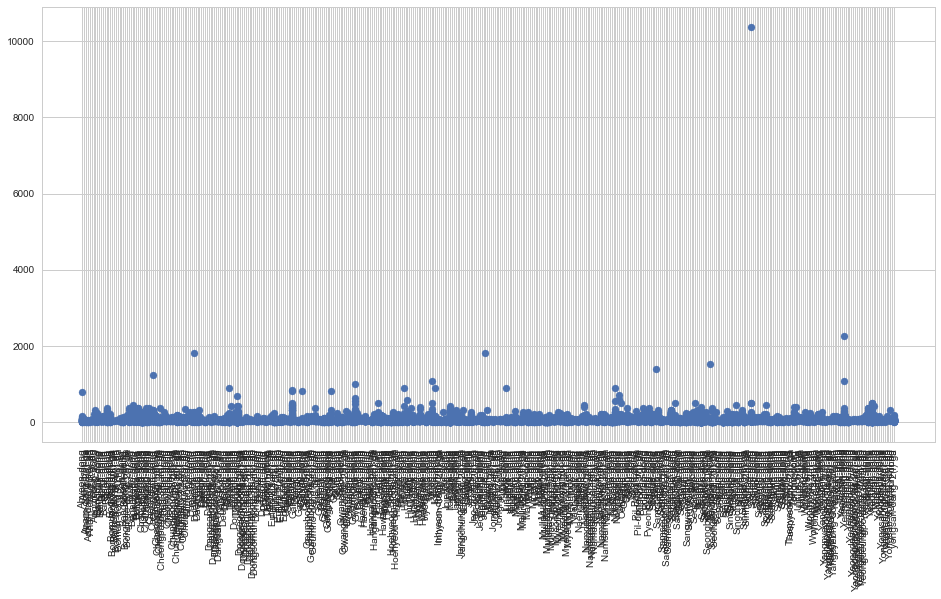

In [37]:
plt.figure(figsize= (16,8))
plt.xticks(rotation=90)

plt.scatter(seoul_airbnb['neighborhood'], seoul_airbnb['price'])
plt.show()

In [20]:
nbh_price = seoul_airbnb[seoul_airbnb["overall_satisfaction"] >= 4.0][['neighborhood','price', 'latitude', 'longitude', 'overall_satisfaction']].copy()

nbh_price_max = nbh_price.groupby(['neighborhood'])["price"].max().reset_index(name='price')
nbh_price_min = nbh_price.groupby(['neighborhood'])["price"].min().reset_index(name='price')
#nbh_price_max.reindex()
#.set_index(['neighborhood','price'])
#nbh_price_max.index.names = ['neighborhood','price']
#print(nbh_price.head(10))
#print(nbh_price_max.head(10))
topx = 1000
nbh_price_maxtop = pd.merge(nbh_price, nbh_price_max, how='inner', on=['neighborhood','price']).sort_values('price', ascending=False).head(topx)
nbh_price_maxtop['text'] = 'Price : ' + nbh_price_maxtop['price'].astype(str) + '; satisfaction : ' + nbh_price_maxtop['overall_satisfaction'].astype(str)

nbh_price_mintop = pd.merge(nbh_price, nbh_price_min, how='inner', on=['neighborhood','price']).sort_values('price', ascending=False).head(topx)
nbh_price_mintop['text'] = 'Price : ' + nbh_price_mintop['price'].astype(str) + '; satisfaction : ' + nbh_price_mintop['overall_satisfaction'].astype(str)

print(nbh_price_maxtop.size)
print(nbh_price_mintop.size)

2418
2868


In [21]:
nbh_price_maxtop.head()

,neighborhood,price,latitude,longitude,overall_satisfaction,text
101,Yeoksam-dong,2266.0,37.496705,127.036230,4.5,Price : 2266.0; satisfaction : 4.5
102,Gye-dong,631.0,37.584675,126.986513,5.0,Price : 631.0; satisfaction : 5.0
106,Yeonnam-dong,495.0,37.560863,126.923865,5.0,Price : 495.0; satisfaction : 5.0
13,Gahoe-dong,495.0,37.583281,126.983069,4.0,Price : 495.0; satisfaction : 4.0
332,Songhyeon-dong,451.0,37.577399,126.981914,5.0,Price : 451.0; satisfaction : 5.0


In [22]:
nbh_price_mintop.head()

,neighborhood,price,latitude,longitude,overall_satisfaction,text
132,Songhyeon-dong,226.0,37.577369,126.981526,5.0,Price : 226.0; satisfaction : 5.0
136,Jeong-dong,175.0,37.562997,126.971283,5.0,Price : 175.0; satisfaction : 5.0
133,Yongsan-dong 4(sa)-ga,155.0,37.534086,126.988126,5.0,Price : 155.0; satisfaction : 5.0
137,Wonhyoro 2(i)-ga,127.0,37.537121,126.963098,5.0,Price : 127.0; satisfaction : 5.0
138,Gyeonji-dong,124.0,37.572862,126.982475,4.5,Price : 124.0; satisfaction : 4.5


In [23]:
import plotly
from plotly.graph_objs import *

mapbox_access_token = 'pk.eyJ1IjoiaGVsaXVtNDAwMCIsImEiOiJjamdvdWpvbzExbWJuMndybWNycmg5NGRrIn0.tGTyZrrWK3qDBwwIb1XXxg'

mapdata = Data([
    Scattermapbox(
        lat=nbh_price_maxtop['latitude'],
        lon=nbh_price_maxtop['longitude'],
        mode='markers',
        marker=Marker(
            size=14,
            color='rgb(255, 0, 0)'
        ),
        text=nbh_price_maxtop['text'],
        name='MAX price'
    ),
    Scattermapbox(
        lat=nbh_price_mintop['latitude'],
        lon=nbh_price_mintop['longitude'],
        mode='markers',
        marker=Marker(
            size=14,
            color='rgb(0, 0, 255)'
        ),
        text=nbh_price_mintop['text'],
        name='MIN price'
    )
])
maplayout = Layout(
    title = 'Airbnb Seoul- Neighbourhood VS Price',
    autosize=False,
    width=1000, 
    height=1000,
    hovermode='closest',
    mapbox=dict(
        accesstoken=mapbox_access_token,
        bearing=0,
        center=dict(
            lat=37.558455,
            lon=126.978283
        ),
        pitch=0,
        zoom=10
    ),
)

plotly.offline.init_notebook_mode(connected=True)
plotly.offline.iplot({
    "data": mapdata,
    "layout": maplayout
})

#### Some thoughts: 
1. What if you wanna invest a house in Seoull & rent it as airbnb, and you want to maximize customer satisfaction, and hence income. 
   - Which location is the best to start? 
   - ** North area above the river **
2. After choosing the location 
   - what pricing strategy should you go for?
3. studying the data, might give you a better understanding of the optimal choice :)


## Satisfaction VS GPS Location

In [24]:
columns_map = ['latitude', 'longitude', 'overall_satisfaction', 'reviews', 'price']
seoul_map = seoul_airbnb[columns_map].copy()

sample_size = 1000
score_above4 = seoul_map[seoul_map["overall_satisfaction"] >= 4.0].sample(sample_size)
score_above4['text'] = 'Price : ' + score_above4['price'].astype(str) + '; satisfaction : ' + score_above4['overall_satisfaction'].astype(str)
print(score_above4.size)
score_above4.head()

6000


,latitude,longitude,overall_satisfaction,reviews,price,text
8417,37.557960,126.927992,5.0,21,66.0,Price : 66.0; satisfaction : 5.0
3786,37.562165,126.984002,5.0,4,72.0,Price : 72.0; satisfaction : 5.0
5308,37.554255,126.967374,5.0,17,47.0,Price : 47.0; satisfaction : 5.0
8815,37.558829,126.925188,4.5,71,52.0,Price : 52.0; satisfaction : 4.5
382,37.533353,126.998078,5.0,9,20.0,Price : 20.0; satisfaction : 5.0


In [25]:
score_less4 = seoul_map[(seoul_map["reviews"] > 0) & (seoul_map["overall_satisfaction"] < 4.0)].sample(sample_size)
score_less4['text'] = 'Price : ' + score_less4['price'].astype(str) + '; satisfaction : ' + score_less4['overall_satisfaction'].astype(str)
print(len(score_less4))
score_less4.head()

1000


,latitude,longitude,overall_satisfaction,reviews,price,text
9278,37.592247,126.913753,0.0,1,62.0,Price : 62.0; satisfaction : 0.0
11141,37.520709,127.022762,0.0,1,34.0,Price : 34.0; satisfaction : 0.0
10256,37.551879,126.973852,0.0,1,40.0,Price : 40.0; satisfaction : 0.0
1643,37.579425,126.967574,0.0,1,595.0,Price : 595.0; satisfaction : 0.0
663,37.555523,127.039552,0.0,1,36.0,Price : 36.0; satisfaction : 0.0


In [26]:
import plotly
from plotly.graph_objs import *

mapbox_access_token = 'pk.eyJ1IjoiaGVsaXVtNDAwMCIsImEiOiJjamdvdWpvbzExbWJuMndybWNycmg5NGRrIn0.tGTyZrrWK3qDBwwIb1XXxg'

mapdata1 = Data([
    Scattermapbox(
        lat=score_above4['latitude'],
        lon=score_above4['longitude'],
        mode='markers',
        marker=Marker(
            size=14,
            color='rgb(255, 0, 0)'
        ),
        text=score_above4['text'],
        name='Satisfaction >= 4.0'
    ),
    Scattermapbox(
        lat=score_less4['latitude'],
        lon=score_less4['longitude'],
        mode='markers',
        marker=Marker(
            size=14,
            color='rgb(0, 0, 255)'
        ),
        text=score_less4['text'],
        name='Satisfaction < 4.0'
    )
])
maplayout = Layout(
    title = 'Airbnb Seoul - Satisfaction',
    autosize=False,
    width=1000, 
    height=1000,
    hovermode='closest',
    mapbox=dict(
        accesstoken=mapbox_access_token,
        bearing=0,
        center=dict(
            lat=37.558455,
            lon=126.978283
        ),
        pitch=0,
        zoom=10
    ),
)

plotly.offline.init_notebook_mode(connected=True)
plotly.offline.iplot({
    "data": mapdata1,
    "layout": maplayout
})